In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import signal as sg
from scipy.stats import linregress
from scipy.optimize import curve_fit

from pyspark.sql.functions import udf, col, abs, lead, isnan
from pyspark.sql.types import BooleanType
from pyspark.sql import functions as sf
from pyspark.sql import Window

import random
import time

In [0]:
#######################################
# Set RNG seed for reproducible results
#######################################
np.random.seed(42)
random.seed(42)

In [0]:
# List directory
dbutils.fs.ls("/FileStore/")

# Remove saved plots
dbutils.fs.rm("/FileStore/plots/", True)

In [0]:
###########################
# Display system properties
###########################
%sh lscpu

Architecture: x86_64
CPU op-mode(s): 32-bit, 64-bit
Byte Order: Little Endian
CPU(s): 2
On-line CPU(s) list: 0,1
Thread(s) per core: 2
Core(s) per socket: 1
Socket(s): 1
NUMA node(s): 1
Vendor ID: GenuineIntel
CPU family: 6
Model: 79
Model name: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
Stepping: 1
CPU MHz: 2699.896
CPU max MHz: 3000.0000
CPU min MHz: 1200.0000
BogoMIPS: 4600.00
Hypervisor vendor: Xen
Virtualization type: full
L1d cache: 32K
L1i cache: 32K
L2 cache: 256K
L3 cache: 46080K
NUMA node0 CPU(s): 0,1
Flags: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch cpuid_fault invpcid_single pti fsgsbase bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx xsaveopt

In [0]:
############################
# MDR dataset pre-processing
############################

input_data_source = "/FileStore/tables/apac_MDR4_PNC925060333_SN82971631_0419.csv"
appliance_id = "925060333_00:82971631-C83DD42B5CFF"

# Constants
ACCEPTABLE_RANGES = {
    "DefrostTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "SensorTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "AmbientTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "TargetTemperature": {
        "CR1": [2, 7],
        "CR1/RC1": [2, 7],
        "CR1/IC1": [-35, 0],
        "CR1/FC1": [-23, 0],
        "CR1/XC1": [-23, 7]
    },
    "CompressorSpeed": {
        "CR1": [0, 4500],
        "CR1/RC1": [0, 4500],
        "CR1/IC1": [0, 4500],
        "CR1/FC1": [0, 4500],
        "CR1/XC1": [0, 4500]
    },
    "WaterFilterFlow": {
        "CR1": [100, 250],
        "CR1/RC1": [100, 250],
        "CR1/IC1": [100, 250],
        "CR1/FC1": [100, 250],
        "CR1/XC1": [100, 250]
    }
}

USEFUL_COLUMNS = ["id", "source_ts", "gateway_ts", "appliance_id", "pnc", "sn", "module_path", "property_name", "value",
                  "value_code", "is_parent", "parent_id", "prev_value", "value_type"]

COEFFICIENT_BASED_COMPOSED_SIGNALS = ['SensorTemperature', 'AmbientTemperature', 'DefrostTemperature',
                                      'TargetTemperature', 'CompressorSpeed', 'WaterFilterFlow']

NUMBER_OF_DECIMALS = 5

def get_containers(df_to_process):
    return df_to_process.filter(df_to_process.value_code == "Container")


def get_null_for_column(df_to_process, column):
    return df_to_process.filter("{} is null".format(column))


def resolution_temperature_speed(props, vals):
    try:
        coef_index = props.index('Coefficient')
        coef_val = vals[coef_index]
    except ValueError:
        return None

    try:
        expo_index = props.index('Exponent')
        expo_val = vals[expo_index]
    except ValueError:
        return None

    return int(coef_val) * (10 ** int(expo_val))


def resolution_default(props, vals):
    props = ';'.join(str(e) for e in props)
    values = ';'.join(str(e) for e in vals)
    return 'defaultComputation: ' + props + '=' + values


def compose_value_udf(property_name, props, vals):
    if property_name in COEFFICIENT_BASED_COMPOSED_SIGNALS:
        value = resolution_temperature_speed(props, vals)
    else:
        value = resolution_default(props, vals)

    return value


compose_value = spark.udf.register("compose_value", compose_value_udf)


def list_to_string_udf(list):
    return ';'.join(list)


list_to_string = spark.udf.register("list_to_string", list_to_string_udf)


def compose_containers(df_to_process):
    df1 = df_to_process
    df2 = df1.select(*(col(x).alias('p_' + x) for x in df1.columns))
    left_join = df1.join(df2, df1.parent_id == df2.p_id, how='left')
    only_base_from_left_join = left_join.where('parent_id is not null').groupBy("parent_id").agg(
        sf.first("p_source_ts").alias("source_ts"),
        sf.first("p_gateway_ts").alias("gateway_ts"),
        sf.first("p_appliance_id").alias("appliance_id"),
        sf.first("p_pnc").alias("pnc"),
        sf.first("p_sn").alias("sn"),
        sf.first("p_module_path").alias("module_path"),
        sf.first("p_property_name").alias("property_name"),
        sf.collect_list("property_name").alias('properties'),
        sf.collect_list("value").alias('value'),
        sf.collect_list("value_code").alias('value_code'),
        sf.first("p_is_parent").alias("is_parent"),
        sf.first("parent_id").alias("parent_id_of_base"),
        sf.collect_list("prev_value").alias('prev_value'),
        sf.collect_list("value_type").alias('value_type')
    )

    composed_containers_as_list = only_base_from_left_join.selectExpr("parent_id as id", "source_ts", "gateway_ts",
                                                                      "appliance_id", "pnc", "sn", "module_path",
                                                                      "property_name", "properties", "value",
                                                                      "value_code", "is_parent",
                                                                      "parent_id_of_base as parent_id", "prev_value",
                                                                      "value_type")

    composed_containers = composed_containers_as_list.select("id", "source_ts", "gateway_ts", "appliance_id", "pnc",
                                                             "sn", "module_path", "property_name",
                                                             compose_value(col("property_name"), col("properties"),
                                                                           col("value")).alias('value'),
                                                             list_to_string(col('value_code')).alias('value_code'),
                                                             "is_parent", "parent_id",
                                                             list_to_string(col("prev_value")).alias('prev_value'),
                                                             list_to_string(col("value_type")).alias('value_type'))

    return composed_containers


def get_simple_properties(df_to_process):
    return df_to_process.filter(
        "{} is null and ({} <> 'Container'  or {} is null)".format("parent_id", "value_code", "value_code"))


def composition(df_to_process):
    composed_containers = compose_containers(df_to_process)
    simple_properties_df = get_simple_properties(df_to_process)
    composed_data_frame = composed_containers.union(simple_properties_df)
    return composed_data_frame.sort('source_ts')


def is_value_valid(property_name, module_path, value):
    try:
        if ACCEPTABLE_RANGES.get(property_name).get(module_path)[0] <= float(value) <= \
                ACCEPTABLE_RANGES.get(property_name).get(module_path)[1]:
            return True
        return False
    except ValueError:
        return True
    except AttributeError:
        return True


filter_outliers_udf = udf(is_value_valid, BooleanType())


def remove_outliers(composed_data_frame_to_process):
    df_with_outliers_removed = composed_data_frame_to_process.filter(
        filter_outliers_udf(composed_data_frame_to_process.property_name, composed_data_frame_to_process.module_path,
                            composed_data_frame_to_process.value))

    return df_with_outliers_removed


def get_difference(initial_df, cleaned_df):
    return initial_df.count() - cleaned_df.count()


def remove_duplicates(df_to_process):
    df_without_duplicates = df_to_process.select("*")
    return df_without_duplicates.dropDuplicates(
        ["source_ts", "gateway_ts", "appliance_id", "pnc", "sn", "module_path", "property_name", "value", "value_code",
         "is_parent", "parent_id", "prev_value", "value_type"])

In [0]:
####################
# Plotting functions
####################
def plot_time_series(time, values, label, plot_points=False):
    plt.figure(figsize=(10,6))
    if plot_points:
      plt.plot(time, values, 'o')
    else:
      plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)
    
def plot_period_hints_acf(acf, period_candidates):
  max_period = np.max(period_candidates)
  max_period = np.rint(max_period).astype(np.int32)

  plt.plot(range(0, max_period * 2), acf[:max_period * 2])

  for period in period_candidates:
    p = np.rint(period).astype(np.int32)
    plt.plot(p, acf[p], 'or')

  plt.xlabel('Time lag (in samples)')
  plt.ylabel('Autocorrelation')
  plt.show()
  
def plot_line_segments(acf, start, end, i, line_1, line_2):
  slope_1, intercept_1 = line_1
  slope_2, intercept_2 = line_2
  
  for j in range(start, start + i):
    plt.plot(j, acf[j], 'ob')

  for j in range(start + i + 1, end + 1):
    plt.plot(j, acf[j], 'og')

  x = np.linspace(start, start + i, 100)
  y = slope_1 * x + intercept_1
  plt.plot(x, y, '-r')

  x = np.linspace(start + i + 1, end + 1, 100)
  y = slope_2 * x + intercept_2
  plt.plot(x, y, '-y')

  plt.grid()
  plt.show()

In [0]:
###########################
# Synthetic data generation
###########################
def generate_sine_wave(time, frequency, sampling_rate, duration, amplitude):
  signal = amplitude * np.sin(2 * np.pi * frequency * time)
  return signal

def generate_noise(num_samples, mean=0.0, stddev=0.1):
  return np.random.normal(mean, stddev, num_samples)

def generate_square_wave(num_samples, start, end, amplitude=1, invert=False):
  if invert:
    signal = np.ones(num_samples) * amplitude
    signal[start:end] = 0
  else:
    signal = np.zeros(num_samples)
    signal[start:end] = amplitude
  return signal

def generate_random_signal(num_samples):  
  time = np.arange(50)
  values = np.where(time < 10, time**3, (time-9)**2)
  
  num_repeats = num_samples // 50
  signal = np.tile(values, num_repeats)
  
  return signal

def generate_signal_with_missing_values(signal, percentage=0.1):
  num_samples = len(signal)
  num_missing_values = np.int32(percentage * num_samples)
  missing_value_indexes = np.random.randint(low=0, high=num_samples - 1, size=num_missing_values)
  
  mask = np.zeros(signal.shape, bool)
  mask[missing_value_indexes] = True

  masked_signal = np.ma.MaskedArray(signal, mask)
  return masked_signal

def generate_impulse_train(num_samples, periodicity=50):
  return sg.unit_impulse(num_samples, np.arange(1, num_samples//periodicity) * periodicity)

In [0]:
#############################################
# Autoperiod evaluation on sinusoidal signals
#############################################
def is_period_valid(detected_period, true_period):
  if 0.95 * true_period <= detected_period <= 1.05 * true_period:
    return True
  return False

def generate_periods(num, min=10, max=500):
  result = []
  p = np.random.randint(min, int(max / 2**(num - 1)))
  result.append(p)
  
  for i in range(1, num):
    p = np.random.randint(2 * p + 1, int(max / 2**(num - i - 1)))
    result.append(p)
  
  return result


def generate_periodic_signal(num_periods, sampling_rate=1, duration=10000, amplitude=1, add_noise=True):
  num_samples = duration * sampling_rate
  time = np.linspace(0, duration, num_samples, endpoint=False)
  
  periods = generate_periods(num_periods)

  frequency = sampling_rate / periods[0]
  signal = generate_sine_wave(time, frequency, sampling_rate, duration, amplitude)
  
  noise = generate_noise(num_samples, stddev=0.5)
  for i in range(1, num_periods):
    frequency = sampling_rate / periods[i]
    signal += generate_sine_wave(time, frequency, sampling_rate, duration, amplitude)
  
  if add_noise:
    signal += noise
  
  return signal, time, periods

def evaluate_autoperiod_sinusoidal(num_iter=100, num_periods=1, debug=False, add_noise=True):
  num_true_positives = 0
  num_false_positives = 0
  num_false_negatives = 0
  
  for i in range(num_iter):
    signal, time, true_periods = generate_periodic_signal(num_periods, add_noise=add_noise)
    
    print("\nIteration ", i + 1)
    print("True periods: ", true_periods)
    
    detected_periods = autoperiod(signal, use_quadratic=True, use_lowpass=True, debug=debug, num_hints_th=5)
    
    if len(detected_periods) == 0:
      num_false_negatives += len(true_periods)
      continue

    period_matching = [[0 for j in range(len(true_periods))] for i in range(len(detected_periods))]
    for i in range(len(detected_periods)):
      for j in range(len(true_periods)):
        if is_period_valid(detected_periods[i], true_periods[j]):
          period_matching[i][j] = 1
          
    period_matching = np.array(period_matching)
    sum_rows = np.sum(period_matching, axis=1)
    sum_cols = np.sum(period_matching, axis=0)
      
    for i in sum_cols:
      if i == 0:
        num_false_negatives += 1
      elif i >= 1:
        num_true_positives += 1
        num_false_positives += (i - 1) 
    
    for i in sum_rows:
      if i == 0:
        num_false_positives += 1
      
  
  print("True positives: ", num_true_positives)
  print("False negatives: ", num_false_negatives)
  print("False positives: ", num_false_positives)
  
  precision = num_true_positives / (num_true_positives + num_false_positives)
  recall = num_true_positives / (num_true_positives + num_false_negatives)
  print("Precision: ", precision)
  print("Recall: ", recall)
  

# Example: evaluate(num_iter=1500, num_periods=1, add_noise=True)

In [0]:
######################
# Autoperiod algorithm
######################

def get_power_threshold(signal, num_permutations=100, confidence=99):
  # Generate 100 permutations of the original signal and select the maximum power from each periodogram
  max_power = []
  for _ in range(num_permutations):
    permutation = np.random.permutation(signal)
    freq, power_spectrum = sg.periodogram(permutation)
    max_power.append(np.max(power_spectrum))

  max_power = np.array(max_power)
  max_power.sort()
  
  # Select the power threshold
  max_power_idx = np.rint(len(max_power) * confidence/100).astype(np.int32)
  power_th = max_power[max_power_idx]
  
  return power_th

def get_period_candidates(signal, debug=False):
  # Compute power threshold
  power_th = get_power_threshold(signal)
  if debug:
    print("Power threshold = {}\n".format(power_th))
  
  # Compute the periodogram of the original sequence
  freq, power_spectrum = sg.periodogram(signal)
  
  # Extract periodicity hints
  period_idx = np.where(power_spectrum > power_th)
  result = freq[period_idx]
  result = np.reciprocal(result)
  
  # Period trimming
  N = len(signal)
  result = result[(result > 2) & (result < N / 2)]
  
  if debug:
    print("Candidate periods: {}\n".format(result))
  return result


def periodicity_hint_clustering(periodicity_hints, N, debug=False):
    clusters = []
    cluster = []
    
    k = N / periodicity_hints[0]
    eps = N / (k - 1) + 1
    cluster.append(periodicity_hints[0])
    
    for hint in periodicity_hints[1:]:
      if hint <= eps:
        cluster.append(hint)
      else:
        clusters.append(cluster)
        cluster = [hint]
      k = N / hint
      eps = N / (k - 1) + 1
      
    clusters.append(cluster)
  
    centroids = []
    for cluster in clusters:
      if len(cluster) == 1:
        centroids.append(cluster[0])
      else:
        mean = sum(cluster) / len(cluster)
        centroids.append(mean)
    
    if (debug):
      print("hints ", periodicity_hints)
      print("clusters ", clusters)
      print("centroids ", centroids)
    return centroids

In [0]:
#################################################
# Validation of periodicity hints - linear method
#################################################

def compute_fitting_error(x, y, slope, intercept):
  y_line = slope * x + intercept
  err = (y - y_line) ** 2
  return np.sum(err)

def get_line_equation(p1, p2):
  x1, y1 = p1
  x2, y2 = p2
  slope = (y2 - y1) / (x2 - x1)
  intercept = y1 - slope * x1
  return slope, intercept

def get_intersection(line_1, line_2):
  slope_1, intercept_1 = line_1
  slope_2, intercept_2 = line_2
  
  x = (intercept_2 - intercept_1) / (slope_1 - slope_2)
  y = slope_1 * x + intercept_1
  return x, y

def determine_concave(line_1, line_2, start, end):
  slope_1, intercept_1 = line_1
  slope_2, intercept_2 = line_2
  
  if slope_1 > 0 and slope_2 < 0:
    return True
  
  if slope_1 < 0 and slope_2 > 0:
    return False
  
  slope, intercept = get_line_equation(start, end)
  x0, y0 = get_intersection(line_1, line_2)
  
  if y0 > slope * x0 + intercept:
    return True
  else:
    return False

def validate_linear(period, signal, acf, debug=False):
  N = len(signal)
  k = N / period
  start = 1/2 * (N/(k+1) + N/k) - 1
  end = 1/2 * (N/k + N/(k-1)) + 1
  
  start = np.rint(start).astype(np.int32)
  end = np.rint(end).astype(np.int32)
  
  errors = []
  lines = []
  
  for i in range(2, end - start - 1):
    slope_1, intercept_1, _, _, _ = linregress(range(start, start + i), acf[start:(start + i)])
    slope_2, intercept_2, _, _, _ = linregress(range(start + i + 1, end + 1), acf[(start + i + 1):(end + 1)])
  
    err_1 = compute_fitting_error(np.array(range(start, start + i)), acf[start:(start + i)], slope_1, intercept_1)
    err_2 = compute_fitting_error(np.array(range(start + i + 1, end + 1)), acf[(start + i + 1):(end + 1)], slope_2, intercept_2)
    # print("i = {}, err_1 = {}, err_2 = {}, total_err = {}".format(i, err_1, err_2, err_1 + err_2))
  
    errors.append(err_1 + err_2)
    lines.append(((slope_1, intercept_1), (slope_2, intercept_2)))
  
  if len(errors) == 0:
    return False
    
  errors = np.array(errors)
  min_err_idx = np.argmin(errors)
  if debug:
    print("Min error index: {}".format(min_err_idx))

  line_1, line_2 = lines[min_err_idx]
  slope_1, intercept_1 = line_1
  slope_2, intercept_2 = line_2
  
  if debug:
    print("Slope 1: {}".format(slope_1))
    print("Slope 2: {}".format(slope_2))
    plot_line_segments(acf, start, end, min_err_idx + 2, line_1, line_2)

  return determine_concave(line_1, line_2, (start, acf[start]), (end, acf[end]))

In [0]:
####################################################
# Validation of periodicity hints - quadratic method
####################################################

def objective_fun(x, a, b, c):
	return a * x**2 + b * x + c

def validate_quadratic(period, signal, acf, debug=False, eps=1e-9):
  start = np.int32(period / 2)
  end = np.int32(period + period / 2)

  x_vals = np.arange(start, end + 1)
  y_vals = acf[start:(end+1)]
  
  popt, _ = curve_fit(objective_fun, x_vals, y_vals)
  a, b, c = popt

  if debug:
    print('Period = ', period)
    print('y = %.5f * x^2 + %.5f * x + %.5f' % (a, b, c))
    
    plt.scatter(x_vals, y_vals)
    x_line = np.arange(min(x_vals), max(x_vals), 1)
    y_line = objective_fun(x_line, a, b, c)
    plt.plot(x_line, y_line, '--', color='red')
    plt.show()
    
  if np.abs(a) < eps and np.abs(b) < eps and np.abs(c) < eps:
    return False
  
  if np.abs(a) < eps:
    return False
  
  x_peak = - b / (2 * a)
  if a < 0 and start <= x_peak <= end:
    return True
  
  return False


def find_local_maximum(seq, x, w=2, max_iter=1000):
  if np.all(seq[x] > seq[(x-w):x]) and np.all(seq[x] > seq[(x+1):(x+w+1)]):
    return x
  
  dir = -1 if seq[x] >= seq[x + 1] else 1
    
  iter = 0
  while iter < max_iter:
    x += dir
    if np.all(seq[x] > seq[(x-w):x]) and np.all(seq[x] > seq[(x+1):(x+w+1)]):
      break
    iter += 1
    dir = -1 if seq[x] >= seq[x + 1] else 1
  return x


def find_local_maximum_impulse(seq, x, N):
  k = N / x
  max_step = x - np.int64(N // (k + 1))
  for i in range(max_step):
    if seq[x + i] != 0:
      return x + i
    elif seq[x - i] != 0:
      return x - i
  return x


def validate_all_hints(periodicity_hints, signal, validation_func, use_lowpass_filter=False, sampling_rate=1, debug=False):
  N = len(signal)
  
  result = []
  filtered_signal = signal

  acf = np.correlate(filtered_signal, filtered_signal, 'full')[-len(filtered_signal):]
  
  for period_idx, period in enumerate(periodicity_hints):
    k = N / period
    
    if(validation_func(period, signal, acf, debug=False)):
        peak = find_local_maximum(acf, int(period), w=3)
        # peak = find_local_maximum_impulse(acf, int(period), N)
        result.append(peak)
        if debug:
          print("Closest peak: {}".format(peak))
          print("Valid period: {}".format(period))
    
    if debug:
      print("Validating period: ", period)
      plot_period_hints_acf(acf, periodicity_hints)
    
    if use_lowpass_filter:
      cutoff_freq = 1 / (N / (k + 1) - 1)
      low_pass_filter = sg.butter(10, cutoff_freq, btype='lowpass', output='sos', analog=False)
      filtered_signal = sg.sosfilt(low_pass_filter, filtered_signal)
      acf = np.correlate(filtered_signal, filtered_signal, 'full')[-len(filtered_signal):]

      if debug:
        print("Applied low pass filter with cutoff = {}, for period = {}".format(cutoff_freq, period))
    
  result = np.unique(result)
  print("Periods found: {}".format(result))
  return result

In [0]:
def autoperiod(signal, use_quadratic=True, use_lowpass_filter=False, sampling_rate=1, num_hints_th=10, debug=False):
  N = len(signal)

  period_candidates = get_period_candidates(signal, debug=debug)
  if len(period_candidates) == 0:
    print("Signal not periodic")
    return []

  # print("Determined periodicity hints")
  
  period_candidates = np.sort(period_candidates)
  if len(period_candidates) > num_hints_th:
    period_candidates = periodicity_hint_clustering(period_candidates, N, debug=debug)
    if debug:
      print("Clustered period candidates: {}".format(period_candidates))
    # print("Clustered periodicity hints")

  # print("Validating {} periodicity hints".format(len(period_candidates)))
  validation_func = validate_quadratic if use_quadratic else validate_linear
  validated_hints = validate_all_hints(period_candidates, signal, validation_func, use_lowpass_filter=use_lowpass_filter, sampling_rate=sampling_rate, debug=debug)
  
  return validated_hints[np.nonzero(validated_hints)]

In [0]:
##################################
# Binary synthetic data generation
##################################

def generate_impulse_train(num_samples, transmission_gaps=[], periodicity=50):
  """ Generate an array of unit impulses with given periodicity, simulating the periodic transmission of a signal. 
  Transmission gaps can be added by specifying missing data intervals. """
  
  signal = sg.unit_impulse(num_samples, np.arange(1, num_samples//periodicity) * periodicity)
  for gap in transmission_gaps:
    signal[gap[0]:gap[1]+1] = 0
  return signal

def generate_impulse_train_missing_data(num_samples, periodicity, missing_data_percentage):
  """ Generate an array of unit impulses with given periodicity, simulating the periodic transmission of a signal. 
  A single transmission gap is added with the specified length. """
  
  if missing_data_percentage > 0.5:
    raise RuntimeError("Cannot have more than 50% of data missing")
  
  indexes = np.arange(1, num_samples//periodicity) * periodicity
  
  if missing_data_percentage > 0:
    num_data_points = len(indexes)

    gap_start_idx = np.random.randint(num_data_points//2)
    gap_end_idx = gap_start_idx + np.int32(missing_data_percentage * num_data_points)
      
    print("Missing data: [{}, {}]".format(indexes[gap_start_idx], indexes[gap_end_idx]))

    indexes = np.delete(indexes, np.arange(gap_start_idx, gap_end_idx))
 
  signal = sg.unit_impulse(num_samples, indexes)
  return signal

def generate_random_impulse_train(length, num_impulses):
  assert num_impulses < length
  indexes = np.random.randint(length - 1, size=num_impulses)
  signal = sg.unit_impulse(length, indexes)
  return signal

In [0]:
##################################
# Binary synthetic data evalution
##################################

def evaluate_autoperiod_synthetic_binary(signal_len, max_iter=100, missing_data_percentage=0, M=30):
  """ Evaluation of augmented Autoperiod algorithm on binary synthetic data.
  Args:
    signal_len(int): length of binary input data
    max_iter(int): number of iterations for computing the accuracy
    missing_data_percentage(float): percentage of signal length in which there is no data (signal is 0)
    M(int): minimum number of data arrival events (timestamps)
  """
  num_detections = 0
  total = 0
  
  for it in range(max_iter):
    print("Iteration ", it + 1)
    true_period = np.random.randint(np.int64(signal_len / (M * (1 + missing_data_percentage))))
    if true_period <= 2:
      continue
      
    print("True periodicity: ", true_period)
    signal = generate_impulse_train_missing_data(signal_len, true_period, missing_data_percentage)
    
    periodicities = autoperiod(signal, use_lowpass_filter=False, debug=False, num_hints_th=5)
    print("Detected periodicities: ", periodicities)
     
    for detected_period in periodicities:
      if is_period_valid(detected_period, true_period):
        num_detections += 1
        break
    
    if len(periodicities) > 0:
      period = max(periodicities)
      print("Detected transmission gaps: ", find_transmission_gaps(signal, period))
    print("\n")
    
    total += 1
  
  accuracy = num_detections / total
  print("Accuracy: ", num_detections / total)
  return accuracy

  
def evaluate_missing_data_fixed_periodicity(signal_len, periodicity, M=30):
  num_detections = 0
  total = 0
  
  print("True periodicity: ", periodicity)
  
  K_vals = np.arange(6) * 0.1
  for K in K_vals:
    print(f"\n\nMissing data percentage: {K}")
    signal = generate_impulse_train_missing_data(signal_len, periodicity, K)
    
    periodicities = autoperiod(signal, use_lowpass_filter=False, debug=False, num_hints_th=5)
    print("Detected periodicities: ", periodicities)
    
    if len(periodicities) > 0:
      period = max(periodicities)
      print("Detected transmission gaps: ", find_transmission_gaps(signal, period))

In [0]:
accuracies = []
for M in range(100, 20, -10):
  accuracies.append(evaluate_autoperiod_synthetic_binary(20000, max_iter=100, missing_data_percentage=0.0, M=M))

Iteration 1
True periodicity: 102
Periods found: [102]
Detected periodicities: [102]
Detected transmission gaps: []


Iteration 2
True periodicity: 145
Periods found: [145]
Detected periodicities: [145]
Detected transmission gaps: []


Iteration 3
True periodicity: 86
Periods found: [86]
Detected periodicities: [86]
Detected transmission gaps: []


Iteration 4
True periodicity: 108
Periods found: [108]
Detected periodicities: [108]
Detected transmission gaps: []


Iteration 5
True periodicity: 111
Periods found: [111]
Detected periodicities: [111]
Detected transmission gaps: []


Iteration 6
True periodicity: 51
Periods found: [51]
Detected periodicities: [51]
Detected transmission gaps: []


Iteration 7
True periodicity: 79
Periods found: [79]
Detected periodicities: [79]
Detected transmission gaps: []


Iteration 8
True periodicity: 146
Periods found: [146]
Detected periodicities: [146]
Detected transmission gaps: []


Iteration 9
True periodicity: 193
Periods found: [193]
Detected periodicities: [193]
Detected transmission gaps: []


Iteration 10
True periodicity: 152
Periods found: [152]
Detected periodicities: [152]
Detected transmission gaps: []


Iteration 11
True periodicity: 124
Periods found: [124]
Detected periodicities: [124]
Detected transmission gaps: []


Iteration 12
True periodicity: 17
Periods found: [17]
Detected periodicities: [17]
Detected transmission gaps: []


Iteration 13
True periodicity: 143
Periods found: [143]
Detected periodicities: [143]
Detected transmission gaps: []


Iteration 14
True periodicity: 185
Periods found: [185]
Detected periodicities: [185]
Detected transmission gaps: []


Iteration 15
True periodicity: 126
Periods found: [126]
Detected periodicities: [126]
Detected transmission gaps: []


Iteration 16
True periodicity: 57
Periods found: [57]
Detected periodicities: [57]
Detected transmission gaps: []


Iteration 17
True periodicity: 117
Periods found: [117]
Detected periodicities: [117]
Detected transmission gaps: []


Iteration 18
True periodicity: 193
Periods found: [193]
Detected periodicities: [193]
Detected transmission gaps: []


Iteration 19
True periodicity: 163
Periods found: [163]
Detected periodicities: [163]
Detected transmission gaps: []


Iteration 20
True periodicity: 85
Periods found: [85]
Detected periodicities: [85]
Detected transmission gaps: []


Iteration 21
True periodicity: 65
Periods found: [65]
Detected periodicities: [65]
Detected transmission gaps: []


Iteration 22
True periodicity: 137
Periods found: [137]
Detected periodicities: [137]
Detected transmission gaps: []


Iteration 23
True periodicity: 9
Periods found: [9]
Detected periodicities: [9]
Detected transmission gaps: []


Iteration 24
True periodicity: 96
Periods found: [96]
Detected periodicities: [96]
Detected transmission gaps: []


Iteration 25
True periodicity: 83
Periods found: [83]
Detected periodicities: [83]
Detected transmission gaps: []


Iteration 26
True periodicity: 15
Periods found: [15]
Detected periodicities: [15]
Detected transmission gaps: []


Iteration 27
True periodicity: 95
Periods found: [95]
Detected periodicities: [95]
Detected transmission gaps: []


Iteration 28
True periodicity: 130
Periods found: [130]
Detected periodicities: [130]
Detected transmission gaps: []


Iteration 29
True periodicity: 90
Periods found: [90]
Detected periodicities: [90]
Detected transmission gaps: []


Iteration 30
True periodicity: 118
Periods found: [118]
Detected periodicities: [118]
Detected transmission gaps: []


Iteration 31
True periodicity: 128
Periods found: [128]
Detected periodicities: [128]
Detected transmission gaps: []


Iteration 32
True periodicity: 165
Periods found: [165]
Detected periodicities: [165]
Detected transmission gaps: []


Iteration 33
True periodicity: 120
Periods found: [120]
Detected periodicities: [120]
Detected transmission gaps: []


Iteration 34
True periodicity: 193
Periods found: [193]
Detected periodicities: [193]
Detected transmission gaps: []


Itera

In [0]:
accuracies

Out[182]: [1.0,
 1.0,
 1.0,
 0.98989898989899,
 0.9693877551020408,
 0.93,
 0.91,
 0.7878787878787878]

Out[187]:

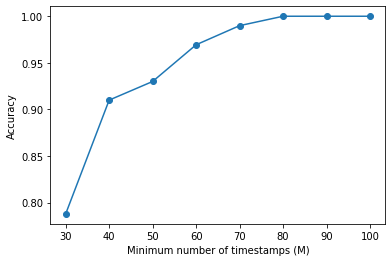

Text(0, 0.5, 'Accuracy')

In [0]:
plt.plot(range(100, 20, -10), accuracies, marker='o')
plt.xlabel("Minimum number of timestamps (M)")
plt.ylabel("Accuracy")

In [0]:
evaluate_missing_data_fixed_periodicity(signal_len=20000, periodicity=150, M=100)

True periodicity: 150


Missing data percentage: 0.0
Periods found: [150]
Detected periodicities: [150]
Detected transmission gaps: []


Missing data percentage: 0.1
Missing data: [1200, 3150]
Periods found: [150]
Detected periodicities: [150]
Detected transmission gaps: [(1051, 3149)]


Missing data percentage: 0.2
Missing data: [6300, 10200]
Periods found: [150]
Detected periodicities: [150]
Detected transmission gaps: [(6151, 10199)]


Missing data percentage: 0.30000000000000004
Missing data: [4950, 10800]
Periods found: [ 0 150]
Detected periodicities: [150]
Detected transmission gaps: [(4801, 10799)]


Missing data percentage: 0.4
Missing data: [750, 8550]
Periods found: [150]
Detected periodicities: [150]
Detected transmission gaps: [(601, 8549)]


Missing data percentage: 0.5
Missing data: [6900, 16800]
Periods found: [ 0 150]
Detected periodicities: [150]
Detected transmission gaps: [(6751, 16799)]

In [0]:
########################################################
# Transmission gaps identification for Autoperiod method
########################################################

def find_transmission_gaps(signal, period, tol=0.1, start_ts=None):
  """ Identify transmission gaps given the binary representation of timestamps.
  Args:
    signal(np.ndarray): binary array encoding the presence or absence of timestamps
    period(int): identified transmission periodicity
    tol(float): tolerance parameter for transmission gaps
    start_ts(pd.Timestamp): used to convert transmission gaps back to timestamps
  Returns:
    a list of identified transmission gaps
  """
  gaps = []
  
  start_idx = 0
  count = 0
  for i in range(len(signal)):
    if signal[i] == 0:
      count += 1
    else:
      if count > (1 + tol) * period:
        gaps.append((start_idx, start_idx + count - 1))
      start_idx = i + 1
      count = 0
      
  if start_ts is None:
    return gaps
  
  result = []
  for gap in gaps:
    result.append((start_ts + pd.Timedelta(seconds=gap[0]), start_ts + pd.Timedelta(seconds=gap[1]), gap[1] - gap[0]))
  return result

In [0]:
#########################
# Periodicity algorithm 1
#########################

def detect_transmission_periodicity_A1(df, start_ts, end_ts, TH=10, hist_bins=100, rm_duplicates=False, debug=False):
  """ Detect periodicity in extracted signal.
  Args:
    df(pd.DataFrame): input signal, with timestamp column named 'source_ts'
    start_ts, end_ts: time interval considered
    TH(int): periodicity threshold
    hist_bins(int): number of bins for the histogram
    rm_duplicates(bool): remove duplicate timestamps (period(t) == 0)
    
  Returns:
    transmission periodicity of signal
  """
  df = df[(df.source_ts >= start_ts) & (df.source_ts <= end_ts)]
  df = df.reset_index(drop=True)
  
  df['next'] = df.shift(-1)
  df.dropna(inplace=True)
  df['period'] = (df['next'] - df['source_ts']).dt.total_seconds()
  
  if rm_duplicates:
    df = remove_duplicate_timestamps(df)
  
  if debug:
    ax = df.plot.line(x='source_ts', y='period', title="period(t) function")
    ax.set_xlabel("source_ts")
    ax.set_ylabel("period")
    plt.show()
  
  return get_signal_period(df, hist_bins, TH)
  
def get_period_histogram(df, num_bins, TH, remove_outliers=False):
  """ Compute histogram of period(t) function and decide whether the signal is periodic.
  Args:
    df(pd.DataFrame): input signal, with precomputed values for column named 'period'
    num_bins(int): number of bins for the histogram
    TH(int): periodicity threshold
    remove_outliers(bool): remove outlier values from period(t) prior to building the histogram
  
  Returns:
    transmission periodicity identified, -1 otherwise
    values of histogram bins
  """
  if remove_outliers:
    period_mean = df.period.mean()
    period_std = df.period.std()
    print(f"Period(t): mean={period_mean}, stddev={period_std}")
    df = df[np.abs(df.period - period_mean) < 3 * period_std]
  
  hist_counts, hist_bins, _ = plt.hist(df.period, bins=num_bins)
  plt.xlabel("period(t) value")
  plt.ylabel("counts")
  std_dev = np.std(hist_counts)
  print("Histogram stddev: {:.2f}".format(std_dev))
  
  if std_dev > TH:
    return -1, hist_counts
  else:
    max_value_idx = np.argmax(hist_counts)
    return hist_bins[max_value_idx], hist_counts
  
def remove_duplicate_timestamps(df):
  """ Remove duplicate timestamps (for which period(t) == 0)
  Args:
    df(pd.DataFrame): input signal, with precomputed values for column named 'period'
  
  Returns:
    the modified DataFrame
  """
  df = df[df.period != 0]
  df = df.reset_index(drop=True)
  return df

In [0]:
###############################################
# Periodicity algorithm 2 (modified Autoperiod)
###############################################

def extract_timestamps(df, signal_name, module_path):
  """ Extract the timestamp values for a given property and module.
  Args:
    df(pyspark.DataFrame): input dataset
    signal_name: name of property
    module_path: name of module
  Returns:
    a pd.DataFrame with timestamp values
  """
  df = df.filter(df.property_name == signal_name).filter(df.module_path == module_path)
  signal = df.select("source_ts").orderBy("source_ts")
  return signal.toPandas()

def convert_timestamp_data_to_time_series(timestamps, start_ts, end_ts, resolution_sec=1):
  """ Convert data arrival timestamps into a binary time series. 
  Args:
    timestamps(pd.DataFrame): data arrival timestamps
    start_ts(pd.Timestamp): first timestamp considered
    end_ts(pd.Timestamp): last timestamp considered
    resolution_sec(int): resolution of resulting binary array, in seconds
  Returns:
    binary np.ndarray
  """
  # Start from first valid timestamp, to reduce array size
  time = np.array(timestamps.source_ts - timestamps.source_ts.iloc[0])
  time = time / np.timedelta64(1, 's')
  time = time.astype(np.int64)
  
  signal_len = np.timedelta64(end_ts - start_ts, 's').astype(np.int64)
  
  if resolution_sec != 1:
    time = time / resolution_sec
    time = np.rint(time).astype(np.int64)
    signal_len = signal_len // resolution_sec
  
  signal = np.zeros(signal_len)
  signal[time] = 1
  
  return signal

def detect_transmission_periodicity_A2(timestamps, start_ts, end_ts, resolution_sec=1, get_ts_gaps=False, debug=False):
  """ Apply Autoperiod algorithm on timestamp data. 
  Args:
    timestamps(pd.DataFrame): data arrival timestamps
    start_ts(pd.Timestamp): first timestamp considered
    end_ts(pd.Timestamp): last timestamp considered
    resolution_sec(int): resolution of resulting binary array, in seconds
    get_ts_gaps(bool): find transmission gaps for periodic signal
  Returns:
    list of identified periodicities
    optional, a list of identified transmission gaps
  """
  
  timestamps = timestamps[(timestamps.source_ts >= start_ts) & (timestamps.source_ts <= end_ts)]
  print("Number of timestamps:", len(timestamps))
  
  signal = convert_timestamp_data_to_time_series(timestamps, start_ts, end_ts, resolution_sec=resolution_sec)
  if debug:
    print("Converted timestamps; length of binary signal = {}".format(len(signal)))
  
  periodicities = autoperiod(signal, use_lowpass_filter=False, debug=False, num_hints_th=5)
  if debug:
    print("Detected periodicities: ", periodicities)
  
  transmission_gaps = []
  if get_ts_gaps:
    if len(periodicities) > 0:
      period = max(periodicities)
      transmission_gaps = find_transmission_gaps(signal, period, start_ts=timestamps.source_ts.iloc[0])
      print("Detected transmission gaps: ", transmission_gaps)
    
  return periodicities, transmission_gaps

In [0]:
#################################
# Data reading and pre-processing
#################################
df = spark.read.csv(input_data_source, inferSchema=True, header=True)
df = df.filter(df.appliance_id == appliance_id)
df = df.select(USEFUL_COLUMNS)
df.printSchema()

root
-- id: integer (nullable = true)
-- source_ts: timestamp (nullable = true)
-- gateway_ts: timestamp (nullable = true)
-- appliance_id: string (nullable = true)
-- pnc: integer (nullable = true)
-- sn: integer (nullable = true)
-- module_path: string (nullable = true)
-- property_name: string (nullable = true)
-- value: string (nullable = true)
-- value_code: string (nullable = true)
-- is_parent: string (nullable = true)
-- parent_id: integer (nullable = true)
-- prev_value: string (nullable = true)
-- value_type: string (nullable = true)

In [0]:
composed_df = composition(df)
filtered_composed_df = composed_df.filter(composed_df.value.isNotNull())
preprocessed_df = remove_duplicates(filtered_composed_df)
preprocessed_df = remove_outliers(preprocessed_df)

In [0]:
test_signals_config = {
   0: ('DefrostTemperature', 'CR1/FC1'),
   1: ('SensorTemperature', 'CR1/FC1'),
   2: ('AirFilterLifeTime', 'CR1'),
   3: ('WaterFilterLifeTime', 'CR1'),
  
   4: ('FanState', 'CR1/XC1'),
   5: ('EvaporatorFanState', 'CR1/IC1')}

In [0]:
test_config = test_signals_config[0]
test_signal_0 = extract_timestamps(preprocessed_df, test_config[0], test_config[1])

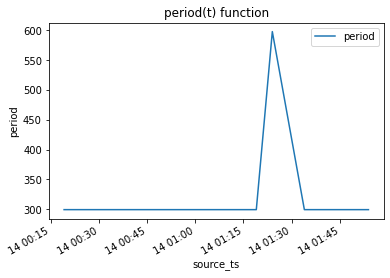

Std dev of histogram: 1.79
Execution time: 0.29 (s)
Signal is periodic with period = 299.0(s) and tolerance = 5(s)

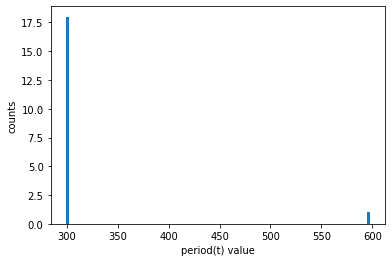

In [0]:
TOL = 5

start_time = time.time()
period, hist_counts = detect_transmission_periodicity_A1(test_signal_0, pd.Timestamp('2019-04-14 00:00:00'), pd.Timestamp('2019-04-14 02:00:00'), TH=TOL, hist_bins=100, rm_duplicates=True, debug=True)
end_time = time.time()
print("Execution time: {:.2f} (s)".format(end_time - start_time))

if period == -1:
  print("Signal not periodic")
else:
  print(f"Signal is periodic with period = {period}(s) and tolerance = {TOL}(s)")

In [0]:
start_time = time.time()
periodicities, gaps = detect_transmission_periodicity_A2(test_signal_0, pd.Timestamp('2019-04-14 00:00:00'), pd.Timestamp('2019-04-14 02:00:00'), resolution_sec=1, get_ts_gaps=True, debug=True)
end_time = time.time()
print("Execution time: {:.2f} (s)".format(end_time - start_time))

Number of timestamps: 21
Converted timestamps; length of binary signal = 7200
Determined periodicity hints
Clustered periodicity hints
Validating 16 periodicity hints
Periods found: [299]
Detected periodicities: [299]
Detected transmission gaps: [(Timestamp('2019-04-14 01:24:01'), Timestamp('2019-04-14 01:33:57'), 596)]
Execution time: 0.11 (s)

In [0]:
test_config = test_signals_config[2]
test_signal_2 = extract_timestamps(preprocessed_df, test_config[0], test_config[1])

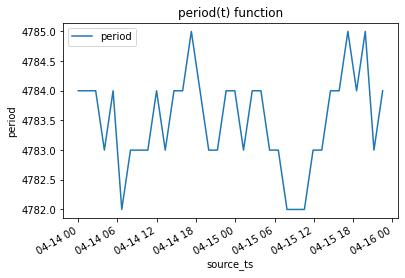

Std dev of histogram: 2.09
Execution time: 0.30 (s)
Signal is periodic with period = 4783.98(s) and tolerance = 5(s)

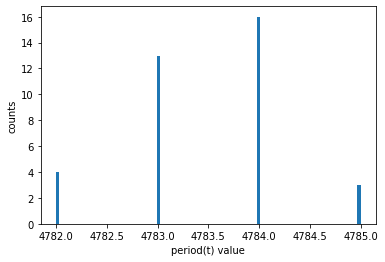

In [0]:
TOL = 5

start_time = time.time()
period, _ = detect_transmission_periodicity_A1(test_signal_2, pd.Timestamp('2019-04-14 00:00:00'), pd.Timestamp('2019-04-16 00:00:00'), TH=TOL, hist_bins=100, rm_duplicates=True, debug=True)
end_time = time.time()
print("Execution time: {:.2f} (s)".format(end_time - start_time))

if period == -1:
  print("Signal not periodic")
else:
  print(f"Signal is periodic with period = {period}(s) and tolerance = {TOL}(s)")

In [0]:
start_time = time.time()
periodicities, gaps = detect_transmission_periodicity_A2(test_signal_2, pd.Timestamp('2019-04-14 00:00:00'), pd.Timestamp('2019-04-16 00:00:00'), resolution_sec=1)
end_time = time.time()
print("Execution time: {:.2f} (s)".format(end_time - start_time))

Number of timestamps: 388
Determined periodicity hints
Clustered periodicity hints
Validating 69 periodicity hints
Periods found: [4784]
Execution time: 18.82 (s)

In [0]:
test_config = test_signals_config[4]
test_signal_4 = extract_timestamps(preprocessed_df, test_config[0], test_config[1])

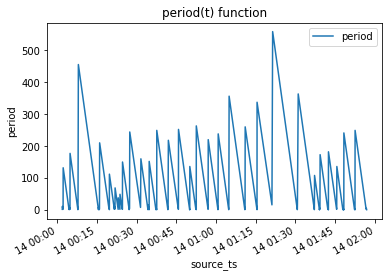

Std dev of histogram: 11.64
Execution time: 0.30 (s)
Signal not periodic

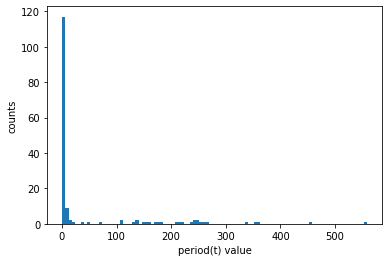

In [0]:
TOL = 5

start_time = time.time()
period, hist_counts = detect_transmission_periodicity_A1(test_signal_4, pd.Timestamp('2019-04-14 00:00:00'), pd.Timestamp('2019-04-14 02:00:00'), TH=TOL, hist_bins=100, rm_duplicates=True, debug=True)
end_time = time.time()
print("Execution time: {:.2f} (s)".format(end_time - start_time))

if period == -1:
  print("Signal not periodic")
else:
  print(f"Signal is periodic with period = {period}(s) and tolerance = {TOL}(s)")

In [0]:
start_time = time.time()
periodicities, gaps = detect_transmission_periodicity_A2(test_signal_4, pd.Timestamp('2019-04-14 00:00:00'), pd.Timestamp('2019-04-14 02:00:00'), resolution_sec=1)
end_time = time.time()
print("Execution time: {:.2f} (s)".format(end_time - start_time))

Number of timestamps: 161
Determined periodicity hints
Clustered periodicity hints
Validating 10 periodicity hints
Periods found: [ 2 150 169 225]
Execution time: 0.11 (s)

In [0]:
test_config = test_signals_config[5]
test_signal_5 = extract_timestamps(preprocessed_df, test_config[0], test_config[1])

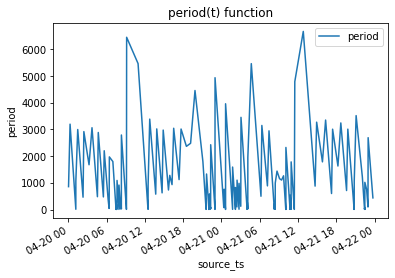

Std dev of histogram: 6.49
Execution time: 0.30 (s)
Signal not periodic

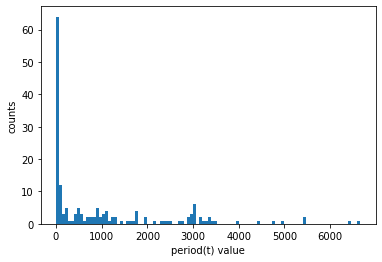

In [0]:
TOL = 5

start_time = time.time()
period, hist_counts = detect_transmission_periodicity_A1(test_signal_5, pd.Timestamp('2019-04-20 00:00:00'), pd.Timestamp('2019-04-22 00:00:00'), TH=TOL, hist_bins=100, rm_duplicates=True, debug=True)
end_time = time.time()
print("Execution time: {:.2f} (s)".format(end_time - start_time))

if period == -1:
  print("Signal not periodic")
else:
  print(f"Signal is periodic with period = {period}(s) and tolerance = {TOL}(s)")

In [0]:
just_date = test_signal['source_ts'].dt.date
just_date.value_counts()